<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/AMZN_STOCK_STATS_AND_PREDICTIVE_MODEL/_AMZN_LSTM_5MIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funcion para obtener los ultimos 100 datos del dia en intervalos de 5 min



In [107]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='AMZN', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos  100 datos intradia
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (5min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=5min&time_period=10&series_type=close&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_1 = obtener_indicadores_trading(symbol='AMZN', api_key='EUD9X61S0RN343RB')
df_final_1

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-04 16:30:00,237.675,242.06,237.3700,237.480,51772.0,239.4330,237.480000,1.953000,4.6900,0.000000,...,0.000,0.000000,0.000000,238.970000,0.000000,237.480000,237.480000,0.000000,0.000000,0.000000
2025-02-04 16:25:00,238.235,242.06,237.5700,237.700,127603.0,239.8623,237.520000,2.342300,4.4900,0.000000,...,0.000,0.000000,0.000000,239.110000,0.000000,237.513846,237.496296,0.017550,0.003510,0.000000
2025-02-04 16:20:00,238.160,238.70,237.3700,238.070,132202.0,240.2814,237.620000,2.661400,1.3300,0.000000,...,0.000,0.000000,0.000000,238.046667,0.000000,237.599408,237.538793,0.060615,0.014931,0.000000
2025-02-04 16:15:00,238.725,242.06,238.0100,238.520,65332.0,240.6564,237.783636,2.872764,4.0500,0.000000,...,0.000,0.000000,0.000000,239.530000,0.000000,237.741038,237.611475,0.129563,0.037857,0.000000
2025-02-04 16:10:00,239.000,242.06,238.4700,238.720,53088.0,240.9819,237.953884,3.028016,3.5900,0.000000,...,0.000,0.000000,0.000000,239.750000,0.000000,237.891647,237.693588,0.198060,0.069898,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 08:35:00,238.460,238.75,238.1700,238.220,15132.0,238.6873,238.560043,0.127257,0.5800,1.216786,...,233.955,75.822222,-0.002053,238.380000,-28.214241,238.653445,239.345992,-0.692547,-0.720069,171345.928571
2025-02-04 08:30:00,238.610,238.68,238.2900,238.480,11790.0,238.7313,238.545489,0.185811,0.3900,1.203929,...,233.955,80.444444,0.000000,238.483333,-15.720174,238.626761,239.281844,-0.655083,-0.707072,144159.785714
2025-02-04 08:25:00,238.815,238.86,238.5600,238.670,8539.0,238.7523,238.568128,0.184172,0.3000,1.159893,...,233.955,83.822222,0.000797,238.696667,9.741406,238.633413,239.236522,-0.603109,-0.686279,110506.714286
2025-02-04 08:20:00,238.900,238.90,238.6900,238.815,8086.0,238.7653,238.613014,0.152286,0.2100,1.082036,...,233.955,86.400000,0.001930,238.801667,30.403538,238.661350,239.205298,-0.543949,-0.657813,15325.357143


In [108]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='AMZN', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (5min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=5min&time_period=10&series_type=close&outputsize=full&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_2 = obtener_indicadores_trading(symbol='AMZN', api_key='EUD9X61S0RN343RB')
df_final_2

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-03 19:55:00,238.75,239.0200,238.75,238.9900,2852.0,238.744,238.990000,-0.246000,0.2700,0.000000,...,0.00,0.000000,0.000000,238.920000,0.000000,238.990000,238.990000,0.000000,0.000000,0.000000
2025-02-03 19:50:00,238.98,238.9800,238.75,238.8699,3638.0,238.723,238.968164,-0.245164,0.2300,0.000000,...,0.00,0.000000,0.000000,238.866633,0.000000,238.971523,238.981104,-0.009581,-0.001916,0.000000
2025-02-03 19:45:00,238.99,238.9900,238.75,238.7800,2757.0,238.686,238.933952,-0.247952,0.2400,0.000000,...,0.00,0.000000,0.000000,238.840000,0.000000,238.942058,238.966207,-0.024149,-0.006363,0.000000
2025-02-03 19:40:00,238.84,238.9900,238.75,238.9900,2594.0,238.701,238.944143,-0.243143,0.2400,0.000000,...,0.00,0.000000,0.000000,238.910000,0.000000,238.949434,238.967970,-0.018536,-0.008797,0.000000
2025-02-03 19:35:00,238.88,238.9899,238.65,238.8650,1235.0,238.672,238.929753,-0.257753,0.3399,0.000000,...,0.00,0.000000,0.000000,238.834967,0.000000,238.936444,238.960342,-0.023898,-0.011818,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 05:05:00,225.73,225.7700,225.69,225.7700,1435.0,225.774,226.050179,-0.276179,0.0800,0.185714,...,225.68,9.278351,-0.000575,225.743333,-104.834474,226.098432,226.334229,-0.235797,-0.184286,3201.428571
2025-01-06 05:00:00,225.73,225.7900,225.69,225.7000,2008.0,225.760,225.986510,-0.226510,0.1000,0.178571,...,225.68,2.298851,-0.000797,225.726667,-97.653334,226.037134,226.287249,-0.250114,-0.197452,3260.142857
2025-01-06 04:55:00,225.65,225.7500,225.65,225.7500,4542.0,225.731,225.943509,-0.212509,0.1000,0.172857,...,225.65,12.048193,-0.001106,225.716667,-91.624622,225.992960,226.247453,-0.254493,-0.208860,3487.142857
2025-01-06 04:50:00,225.74,225.7700,225.65,225.6500,2933.0,225.711,225.890143,-0.179143,0.1200,0.152143,...,225.65,0.000000,-0.001328,225.690000,-89.037239,225.940197,226.203197,-0.263000,-0.219688,2781.428571


In [109]:
import pandas as pd

# Supongamos que tus DataFrames son df1 y df2
df_final = pd.concat([df_final_1, df_final_2])

# Ordenar por índice (fecha) en orden cronológico si es necesario
df_final_1 = df_final.sort_index()

# Mostrar resultado
df_final_1


,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-06 04:45:00,225.670,225.74,225.64,225.74,1129.0,225.7170,225.862845,-0.145845,0.10,0.153571,...,225.64,11.904762,-0.000797,225.706667,-80.372145,225.909397,226.168886,-0.259489,-0.227648,2623.500000
2025-01-06 04:50:00,225.740,225.77,225.65,225.65,2933.0,225.7110,225.890143,-0.179143,0.12,0.152143,...,225.65,0.000000,-0.001328,225.690000,-89.037239,225.940197,226.203197,-0.263000,-0.219688,2781.428571
2025-01-06 04:55:00,225.650,225.75,225.65,225.75,4542.0,225.7310,225.943509,-0.212509,0.10,0.172857,...,225.65,12.048193,-0.001106,225.716667,-91.624622,225.992960,226.247453,-0.254493,-0.208860,3487.142857
2025-01-06 05:00:00,225.730,225.79,225.69,225.70,2008.0,225.7600,225.986510,-0.226510,0.10,0.178571,...,225.68,2.298851,-0.000797,225.726667,-97.653334,226.037134,226.287249,-0.250114,-0.197452,3260.142857
2025-01-06 05:05:00,225.730,225.77,225.69,225.77,1435.0,225.7740,226.050179,-0.276179,0.08,0.185714,...,225.68,9.278351,-0.000575,225.743333,-104.834474,226.098432,226.334229,-0.235797,-0.184286,3201.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 16:10:00,239.000,242.06,238.47,238.72,53088.0,240.9819,237.953884,3.028016,3.59,0.000000,...,0.00,0.000000,0.000000,239.750000,0.000000,237.891647,237.693588,0.198060,0.069898,0.000000
2025-02-04 16:15:00,238.725,242.06,238.01,238.52,65332.0,240.6564,237.783636,2.872764,4.05,0.000000,...,0.00,0.000000,0.000000,239.530000,0.000000,237.741038,237.611475,0.129563,0.037857,0.000000
2025-02-04 16:20:00,238.160,238.70,237.37,238.07,132202.0,240.2814,237.620000,2.661400,1.33,0.000000,...,0.00,0.000000,0.000000,238.046667,0.000000,237.599408,237.538793,0.060615,0.014931,0.000000
2025-02-04 16:25:00,238.235,242.06,237.57,237.70,127603.0,239.8623,237.520000,2.342300,4.49,0.000000,...,0.00,0.000000,0.000000,239.110000,0.000000,237.513846,237.496296,0.017550,0.003510,0.000000


In [110]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar todas las columnas
df_final = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns, index=df_final.index)

# Ahora usar df_scaled en lugar de df_final
df_final

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-04 16:30:00,0.820374,0.729247,0.916750,0.813502,0.002937,0.897295,0.823191,0.511640,0.135026,0.000000,...,0.000000,0.000000,0.330605,0.884677,0.500985,0.824727,0.830994,0.361438,0.356633,0.000000
2025-02-04 16:25:00,0.841308,0.729247,0.920162,0.821708,0.007240,0.913607,0.824716,0.548334,0.129256,0.000000,...,0.000000,0.000000,0.330605,0.888517,0.500985,0.826022,0.831627,0.365421,0.357538,0.000000
2025-02-04 16:20:00,0.838505,0.636152,0.916750,0.835509,0.007500,0.929531,0.828529,0.578411,0.038084,0.000000,...,0.000000,0.000000,0.330605,0.859348,0.500985,0.829294,0.833278,0.375197,0.360483,0.000000
2025-02-04 16:15:00,0.859626,0.729247,0.927668,0.852294,0.003706,0.943780,0.834768,0.598334,0.116561,0.000000,...,0.000000,0.000000,0.330605,0.900038,0.500985,0.834711,0.836102,0.390848,0.366396,0.000000
2025-02-04 16:10:00,0.869907,0.729247,0.935515,0.859754,0.003012,0.956148,0.841260,0.612967,0.103289,0.000000,...,0.000000,0.000000,0.330605,0.906073,0.500985,0.840471,0.839292,0.406397,0.374659,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 05:05:00,0.373832,0.277901,0.717501,0.376725,0.000081,0.378296,0.387380,0.301524,0.002020,0.040412,...,0.934145,0.092784,0.319227,0.521845,0.315337,0.389420,0.398012,0.307912,0.309106,0.001879
2025-01-06 05:00:00,0.373832,0.278455,0.717501,0.374114,0.000113,0.377764,0.384952,0.306206,0.002597,0.038858,...,0.934145,0.022989,0.314850,0.521388,0.328054,0.387075,0.396187,0.304662,0.305711,0.001914
2025-01-06 04:55:00,0.370841,0.277347,0.716819,0.375979,0.000257,0.376662,0.383313,0.307526,0.002597,0.037614,...,0.934020,0.120482,0.308734,0.521113,0.338730,0.385386,0.394641,0.303668,0.302769,0.002047
2025-01-06 04:50:00,0.374206,0.277901,0.716819,0.372249,0.000166,0.375902,0.381278,0.310671,0.003174,0.033107,...,0.934020,0.000000,0.304355,0.520382,0.343312,0.383368,0.392922,0.301737,0.299976,0.001633


# MODELO

Epoch 1/50 - Train Loss: 0.030135, Val Loss: 0.000465
Epoch 2/50 - Train Loss: 0.000798, Val Loss: 0.000180
Epoch 3/50 - Train Loss: 0.000472, Val Loss: 0.000171
Epoch 4/50 - Train Loss: 0.000553, Val Loss: 0.000428
Epoch 5/50 - Train Loss: 0.000456, Val Loss: 0.000106
Epoch 6/50 - Train Loss: 0.000346, Val Loss: 0.000097
Epoch 7/50 - Train Loss: 0.000344, Val Loss: 0.000191
Epoch 8/50 - Train Loss: 0.000377, Val Loss: 0.000167
Epoch 9/50 - Train Loss: 0.000492, Val Loss: 0.000112
Epoch 10/50 - Train Loss: 0.000312, Val Loss: 0.000148
Epoch 11/50 - Train Loss: 0.000372, Val Loss: 0.000112
Epoch 12/50 - Train Loss: 0.000403, Val Loss: 0.000114
Epoch 13/50 - Train Loss: 0.000318, Val Loss: 0.000102
Epoch 14/50 - Train Loss: 0.000334, Val Loss: 0.000117
Epoch 15/50 - Train Loss: 0.000499, Val Loss: 0.000277
Epoch 16/50 - Train Loss: 0.000308, Val Loss: 0.000100
Epoch 17/50 - Train Loss: 0.000333, Val Loss: 0.000173
Epoch 18/50 - Train Loss: 0.000418, Val Loss: 0.000126
Epoch 19/50 - Train

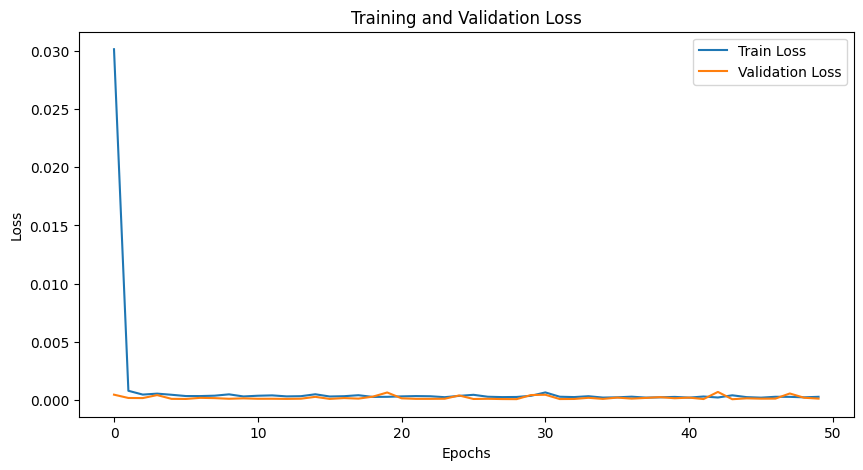

Predicción del precio en los próximos 30 minutos: 225.80
Último precio real (2025-02-04 16:30:00): 237.48
RMSE: 0.0114
MAE: 0.0092


In [111]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 📌 1. Preparación de los Datos (X = Features, Y = Objetivo)
window_size = 30  # Se cambia a 30 minutos

X, Y = [], []
for i in range(len(df_final) - window_size):
    X.append(df_final.iloc[i:i+window_size].values)  # Todas las columnas como entrada
    Y.append(df_final.iloc[i+window_size]['Close'])  # Solo la columna 'Close' como salida

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# 📌 2. División en Entrenamiento y Validación
train_split = 0.8
split = int(len(Y) * train_split)

X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# 📌 3. Creación de Datasets para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Configuración de hiperparámetros
batch_size = 32
learning_rate = 0.01

# Crear datasets y DataLoaders
train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 📌 4. Definir la Arquitectura de la LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Usamos solo la última salida de la secuencia

# 📌 5. Instanciar y Configurar el Modelo
input_size = X.shape[2]  # Número de características
model = LSTMModel(input_size).to("cpu")

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 📌 6. Entrenamiento de la LSTM
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            preds = model(X_batch)
            val_loss += criterion(preds.squeeze(), Y_batch).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# 📌 7. Graficar la Pérdida de Entrenamiento y Validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 📌 8. Hacer Predicción de los Próximos 30 Minutos (con desnormalización)
model.eval()
latest_X = torch.tensor(X[-1], dtype=torch.float32).unsqueeze(0)  # Última secuencia de entrada
predicted_price = model(latest_X).cpu().detach().numpy().flatten()[0]


# 📌 Solución para desnormalizar correctamente
expanded_prediction = np.zeros((1, X.shape[2]))  # Crear un array de ceros con 26 columnas
expanded_prediction[0, 0] = predicted_price  # Insertar el valor predicho en la primera columna

# Desnormalizar correctamente
predicted_price_real = scaler.inverse_transform(expanded_prediction)[0, 0]  # Extraer solo el precio real

print(f"Predicción del precio en los próximos 30 minutos: {predicted_price_real:.2f}")

# 📌 9. Obtener el último precio real del DataFrame
last_real_price_index = df_final_1.index[-1]  # Última fecha y hora registrada
last_real_price = df_final_1.iloc[-1]['Close']  # Último precio real

print(f"Último precio real ({last_real_price_index}): {last_real_price:.2f}")

# 📌 10. Evaluación del Modelo
preds_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        preds = model(X_batch).cpu().numpy().flatten()
        preds_val.extend(preds)

rmse = np.sqrt(mean_squared_error(Y_val, preds_val))
mae = mean_absolute_error(Y_val, preds_val)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# Randm Search

In [105]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# 📌 1. Rango de hiperparámetros para Random Search
param_grid = {
    "hidden_size": [32, 50, 100, 128],
    "num_layers": [1, 2, 3],
    "dropout": [0.1, 0.2, 0.3, 0.5],
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.003, 0.005, 0.01]
}

# 📌 2. Definir el número de combinaciones a probar
num_trials = 10
best_val_loss = float("inf")
best_params = None
best_model = None

# 📌 3. Bucle de Random Search
for trial in range(num_trials):
    # Selección aleatoria de hiperparámetros
    hidden_size = random.choice(param_grid["hidden_size"])
    num_layers = random.choice(param_grid["num_layers"])
    dropout = random.choice(param_grid["dropout"])
    batch_size = random.choice(param_grid["batch_size"])
    learning_rate = random.choice(param_grid["learning_rate"])

    print(f"🔄 Probando configuración: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, batch_size={batch_size}, lr={learning_rate}")

    # 📌 4. Preparar los datos con el nuevo batch_size
    train_loader = DataLoader(TimeSeriesDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

    # 📌 5. Definir la LSTM con los hiperparámetros actuales
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])

    model = LSTMModel(X.shape[2], hidden_size, num_layers, dropout).to("cpu")

    # 📌 6. Definir la función de pérdida y el optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 📌 7. Entrenamiento del modelo con la configuración actual
    num_epochs = 30
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds.squeeze(), Y_batch)
            loss.backward()
            optimizer.step()

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                preds = model(X_batch)
                val_loss += criterion(preds.squeeze(), Y_batch).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"🔹 Final val_loss: {val_loss:.6f}")

    # 📌 8. Guardar la mejor configuración
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = (hidden_size, num_layers, dropout, batch_size, learning_rate)
        best_model = model

print(f"✅ Mejor configuración encontrada: hidden_size={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, batch_size={best_params[3]}, lr={best_params[4]}")
print(f"🔹 Mejor val_loss obtenida: {best_val_loss:.6f}")

# 📌 9. Evaluación final con el mejor modelo
best_model.eval()
preds_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        preds = best_model(X_batch).cpu().numpy().flatten()
        preds_val.extend(preds)

rmse = np.sqrt(mean_squared_error(Y_val, preds_val))
mae = mean_absolute_error(Y_val, preds_val)

print(f"✅ Evaluación final del mejor modelo:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


🔄 Probando configuración: hidden_size=128, num_layers=2, dropout=0.1, batch_size=64, lr=0.003
🔹 Final val_loss: 0.000094
🔄 Probando configuración: hidden_size=32, num_layers=1, dropout=0.3, batch_size=64, lr=0.005


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.000095
🔄 Probando configuración: hidden_size=100, num_layers=1, dropout=0.2, batch_size=32, lr=0.003


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.000075
🔄 Probando configuración: hidden_size=50, num_layers=3, dropout=0.3, batch_size=32, lr=0.01
🔹 Final val_loss: 0.000105
🔄 Probando configuración: hidden_size=50, num_layers=3, dropout=0.1, batch_size=32, lr=0.003
🔹 Final val_loss: 0.000186
🔄 Probando configuración: hidden_size=100, num_layers=1, dropout=0.5, batch_size=128, lr=0.001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.000103
🔄 Probando configuración: hidden_size=32, num_layers=1, dropout=0.3, batch_size=128, lr=0.001
🔹 Final val_loss: 0.000097
🔄 Probando configuración: hidden_size=100, num_layers=3, dropout=0.1, batch_size=32, lr=0.01
🔹 Final val_loss: 0.000073
🔄 Probando configuración: hidden_size=50, num_layers=2, dropout=0.5, batch_size=64, lr=0.001
🔹 Final val_loss: 0.000118
🔄 Probando configuración: hidden_size=50, num_layers=3, dropout=0.5, batch_size=32, lr=0.003
🔹 Final val_loss: 0.000088
✅ Mejor configuración encontrada: hidden_size=100, num_layers=3, dropout=0.1, batch_size=32, lr=0.01
🔹 Mejor val_loss obtenida: 0.000073
✅ Evaluación final del mejor modelo:
RMSE: 0.0087
MAE: 0.0060
